In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import tensorflow as tf
import  tensorflow.keras.layers as tfl
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from random import random
from keras.utils.vis_utils import plot_model

In [3]:
import tensorflow_addons as tfa
from numpy import savez_compressed

In [4]:
def load_images(path, size = (256, 256)):
    data_list = list()
    for filename in os.listdir(path):
        pixels = tf.keras.utils.load_img(path+filename, target_size = size)
        pixels = tf.keras.utils.img_to_array(pixels)
        data_list.append(pixels)
    return np.asarray(data_list)
    

In [5]:
path = "../input/horse2zebra-dataset/"
dataA1 = load_images(path + 'trainA/')
dataA2 = load_images(path + 'testA/')
dataA = np.vstack((dataA1, dataA2))
print('Loaded dataA:', dataA.shape)

Loaded dataA: (1187, 256, 256, 3)


In [6]:
dataB1 = load_images(path + 'trainB/')
dataB2 = load_images(path + 'testB/')
dataB = np.vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)

Loaded dataB:  (1474, 256, 256, 3)


In [7]:
filename = 'horse2zebra_256.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset:', filename)

Saved dataset: horse2zebra_256.npz


In [8]:
data = np.load('horse2zebra_256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded:', dataA.shape, dataB.shape)

Loaded: (1187, 256, 256, 3) (1474, 256, 256, 3)


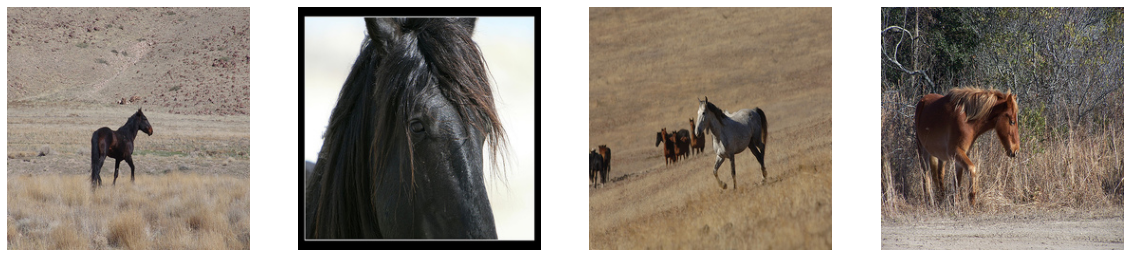

In [9]:
n_samples = 4
plt.figure(figsize = (20,10))
for i in range(n_samples):
    plt.subplot(2, n_samples, i+1)
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
    
    

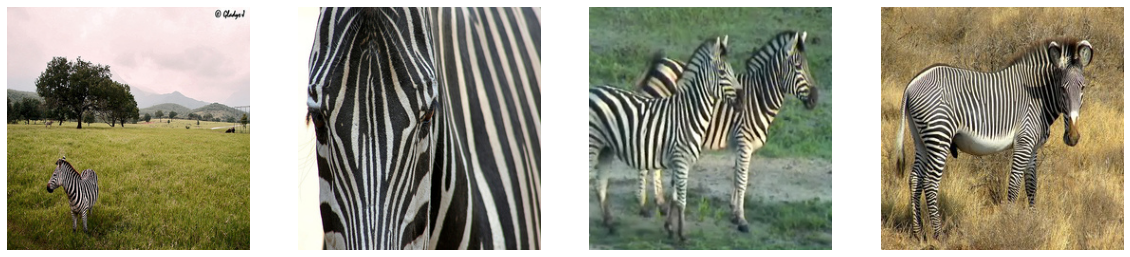

In [10]:
plt.figure(figsize = (20,10))
for i in range(n_samples):
    plt.subplot(2, n_samples, i+1)
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
    

# Discriminator

In [11]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    # source image input
    in_image = tf.keras.Input(shape=image_shape)
    # C64
    d = tfl.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = tfl.LeakyReLU(alpha=0.2)(d)
    # C128
    d = tfl.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = tfl.LeakyReLU(alpha=0.2)(d)
    # C256
    d = tfl.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = tfl.LeakyReLU(alpha=0.2)(d)
    # C512
    d = tfl.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = tfl.LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = tfl.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = tfl.LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = tfl.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    # define model
    model = tf.keras.models.Model(in_image, patch_out)
    # compile model
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

In [12]:
define_discriminator((256, 256, 3)).summary()

2022-11-15 12:53:02.165592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 12:53:02.258706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 12:53:02.259475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 12:53:02.261580: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524544

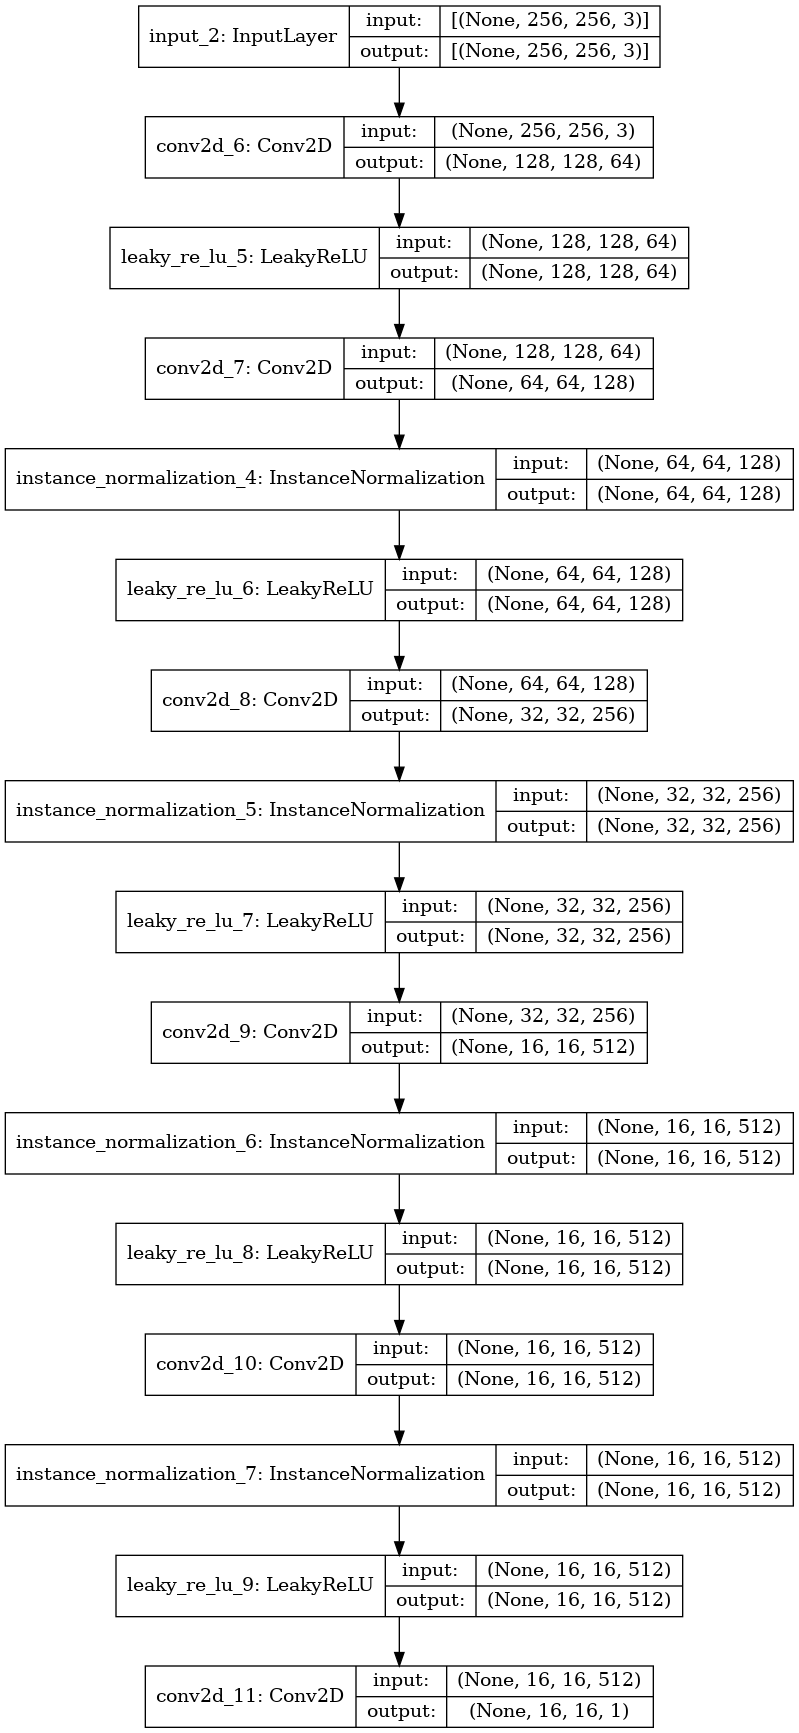

In [13]:
plot_model(define_discriminator((256, 256, 3)), to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Residual Network for Generation

In [14]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = tfl.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    g = tfl.Activation('relu')(g)
    # second convolutional layer
    g = tfl.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = tfl.Concatenate()([g, input_layer])
    return g

# Generator Network

In [15]:
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    # image input
    in_image = tf.keras.Input(shape=image_shape)
    # c7s1-64
    g = tfl.Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    g = tfl.Activation('relu')(g)
    # d128
    g = tfl.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    g = tfl.Activation('relu')(g)
    # d256
    g = tfl.Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    g = tfl.Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # u128
    g = tfl.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    g = tfl.Activation('relu')(g)
    # u64
    g = tfl.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    g = tfl.Activation('relu')(g)
    # c7s1-3
    g = tfl.Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = tfa.layers.InstanceNormalization(axis=-1)(g)
    out_image = tfl.Activation('tanh')(g)
    # define model
    model = tf.keras.models.Model(in_image, out_image)
    return model

In [16]:
define_generator((256, 256,3), n_resnet=9).summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
instance_normalization_8 (Insta (None, 256, 256, 64) 128         conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization_8[0][0]   
____________________________________________________________________________________________

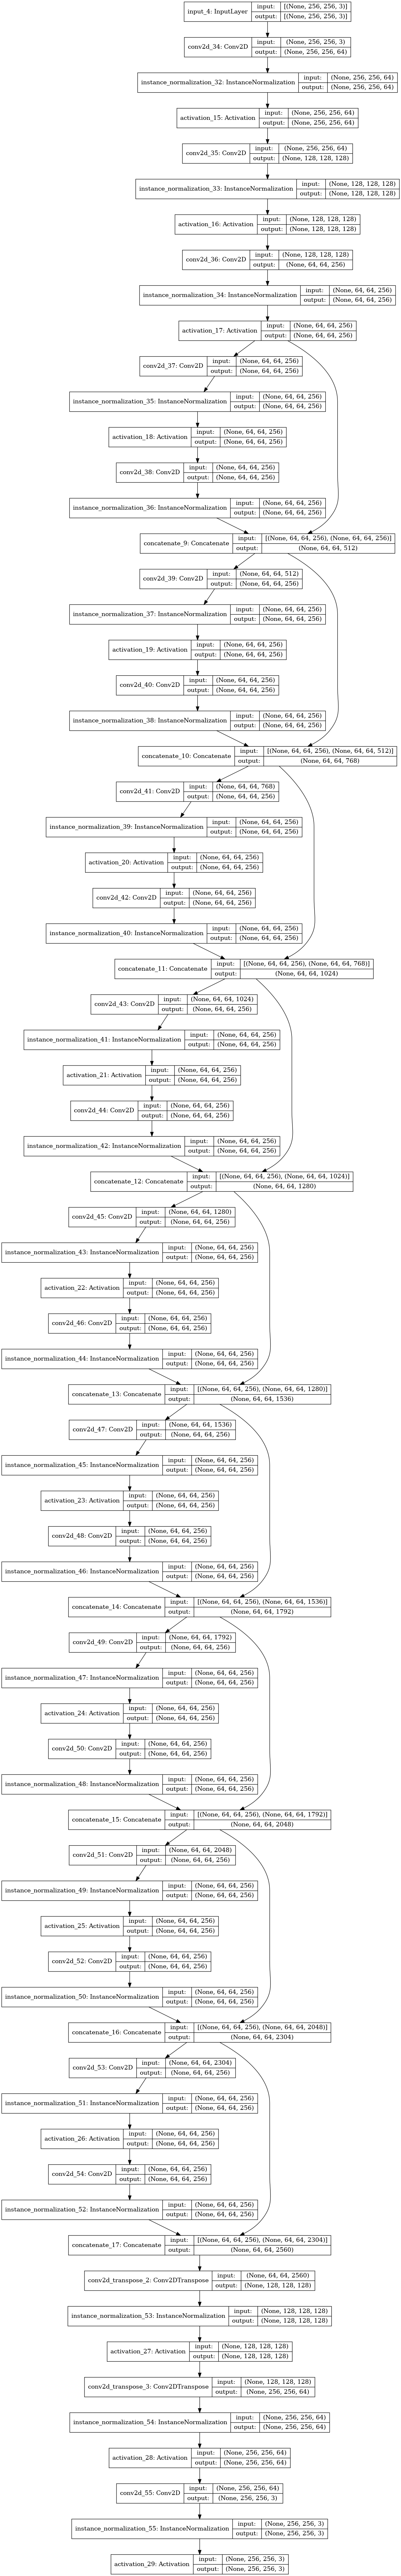

In [17]:
plot_model(define_generator((256, 256,3), n_resnet=9), to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Sustituiting all function to update generator and its cycle loss 

In [18]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # ensure the model we✬re updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = tf.keras.Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = tf.keras.Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = tf.keras.models.Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10],
    optimizer=opt)
    return model

In [19]:
#define_composite_model(g_model_1, d_model, g_model_2, image_shape)

In [20]:
# load and prepare training images
def load_real_samples(filename):
    # load the dataset
    data = np.load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [21]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate ✬real✬ class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [22]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
    # generate fake instance
    X = g_model.predict(dataset)
    # create ✬fake✬ class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y
   

# Saving the models

In [23]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    # save the first generator model
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [24]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_out[i])
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig(filename1)
    plt.close()

In [25]:
 # update image pool for fake images
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
        # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
        # use image, but don✬t add it to the pool
            selected.append(image)
        else:
        # replace an existing image and use replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

In [26]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,dataset):
    # define properties of the training run
    n_epochs, n_batch, = 1, 1
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
    # select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA,X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB,X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        # summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2,dB_loss1,dB_loss2, g_loss1,g_loss2))
        # evaluate the model performance every so often
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        if (i+1) % (bat_per_epo * 1) == 0:
            # save the models
            save_models(i, g_model_AtoB, g_model_BtoA)

In [27]:
# load image data
dataset = load_real_samples('horse2zebra_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (1187, 256, 256, 3) (1474, 256, 256, 3)


2022-11-15 12:53:27.354205: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-15 12:53:29.342200: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


>1, dA[0.702,1.534] dB[0.910,0.993] g[16.613,16.286]
>2, dA[1.190,1.710] dB[0.973,0.831] g[18.186,18.497]
>3, dA[2.518,1.029] dB[2.514,1.338] g[15.819,21.039]
>4, dA[6.657,1.837] dB[4.933,5.897] g[25.049,19.674]
>5, dA[2.827,3.097] dB[1.602,4.893] g[17.193,16.381]
>6, dA[2.085,6.835] dB[1.029,9.285] g[26.438,23.495]
>7, dA[1.709,3.675] dB[1.160,2.939] g[17.428,18.512]
>8, dA[1.117,4.032] dB[2.171,1.951] g[15.307,18.877]
>9, dA[1.667,2.539] dB[0.905,1.033] g[16.997,19.478]
>10, dA[1.796,1.127] dB[1.112,1.110] g[15.148,14.968]
>11, dA[1.032,0.909] dB[0.795,1.634] g[15.904,16.302]
>12, dA[0.825,1.194] dB[1.286,1.703] g[13.953,14.850]
>13, dA[0.685,1.607] dB[0.863,2.733] g[16.500,15.545]
>14, dA[0.908,1.578] dB[1.027,0.779] g[12.962,14.035]
>15, dA[1.255,1.552] dB[0.664,0.835] g[10.847,11.115]
>16, dA[1.867,1.248] dB[0.580,0.714] g[10.389,13.594]
>17, dA[1.464,0.822] dB[0.617,0.656] g[11.283,13.102]
>18, dA[1.223,1.201] dB[0.613,0.931] g[11.079,12.106]
>19, dA[0.540,0.611] dB[0.474,0.900] 

2022-11-15 13:05:47.044583: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>610, dA[0.123,0.070] dB[0.056,0.118] g[5.123,5.643]
>611, dA[0.217,0.263] dB[0.086,0.252] g[4.939,5.241]
>612, dA[0.045,0.062] dB[0.104,0.064] g[8.313,9.003]
>613, dA[0.088,0.246] dB[0.203,0.098] g[6.396,6.402]
>614, dA[0.255,0.126] dB[0.080,0.142] g[6.468,6.090]
>615, dA[0.232,0.119] dB[0.137,0.108] g[6.069,6.446]
>616, dA[0.091,0.187] dB[0.085,0.135] g[5.685,6.962]
>617, dA[0.148,0.170] dB[0.101,0.028] g[7.165,6.915]
>618, dA[0.146,0.101] dB[0.078,0.043] g[8.170,7.157]
>619, dA[0.120,0.090] dB[0.074,0.066] g[6.993,6.814]
>620, dA[0.100,0.149] dB[0.172,0.125] g[8.321,9.633]
>621, dA[0.094,0.158] dB[0.039,0.103] g[5.720,6.325]
>622, dA[0.092,0.122] dB[0.361,0.109] g[5.555,6.584]
>623, dA[0.476,0.238] dB[0.107,0.041] g[5.283,5.432]
>624, dA[0.103,0.095] dB[0.100,0.046] g[8.323,8.584]
>625, dA[0.067,0.305] dB[0.111,0.041] g[6.115,5.790]
>626, dA[0.161,0.057] dB[0.089,0.123] g[5.618,6.052]
>627, dA[0.091,0.131] dB[0.063,0.043] g[7.456,7.260]
>628, dA[0.104,0.022] dB[0.280,0.045] g[5.378,

2022-11-15 13:08:21.897597: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>747, dA[0.291,0.318] dB[0.113,0.215] g[4.996,5.189]
>748, dA[0.176,0.161] dB[0.113,0.064] g[4.938,6.321]
>749, dA[0.241,0.205] dB[0.168,0.221] g[5.180,5.676]
>750, dA[0.079,0.115] dB[0.080,0.135] g[4.775,5.149]
>751, dA[0.239,0.100] dB[0.246,0.171] g[4.835,4.914]
>752, dA[0.049,0.075] dB[0.247,0.189] g[4.905,5.279]
>753, dA[0.285,0.129] dB[0.089,0.051] g[5.357,5.664]
>754, dA[0.121,0.128] dB[0.222,0.175] g[8.740,9.765]
>755, dA[0.141,0.028] dB[0.108,0.233] g[4.903,5.618]
>756, dA[0.118,0.250] dB[0.094,0.091] g[5.823,6.243]
>757, dA[0.047,0.084] dB[0.052,0.164] g[6.894,8.882]
>758, dA[0.386,0.091] dB[0.342,0.049] g[5.786,7.043]
>759, dA[0.150,0.123] dB[0.097,0.361] g[5.980,6.183]
>760, dA[0.045,0.199] dB[0.313,0.085] g[5.018,5.091]
>761, dA[0.114,0.061] dB[0.101,0.105] g[4.354,4.660]
>762, dA[0.096,0.024] dB[0.134,0.177] g[4.081,4.656]
>763, dA[0.036,0.070] dB[0.208,0.110] g[4.800,4.393]
>764, dA[0.042,0.095] dB[0.174,0.113] g[4.977,5.160]
>765, dA[0.221,0.121] dB[0.158,0.138] g[6.333,